In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

In [2]:
# Dataset loading
dataFrame = pd.read_csv('C:\\Users\\stone\\source\\LSTM_test\\data\\final_data_adj.csv')  # https://github.com/SusmitSekharBhakta/Stock-market-price-prediction/blob/main/final_data_adj.csv
print(dataFrame.shape)

(1825, 16)


In [3]:
imputer = SimpleImputer(missing_values=np.nan)  # Handling missing values
dataFrame.drop(columns=['Date'], inplace=True)
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['Open', 'Close']] = target_scaler.fit_transform(dataFrame[['Open', 'Close']].to_numpy())
df_scaled = df_scaled.astype(float)
print(df_scaled.shape)

(1825, 15)


In [4]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['Open', 'Close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)


In [16]:
    # Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
print("xVal shape = ",np.shape(xVal))
print("yVal shape = ",np.shape(yVal))
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]
print("X_train shape =",X_train.shape)
print("y_train shape =",y_train.shape)
print(X_train[1,:,:])

xVal shape =  (1805, 20, 15)
yVal shape =  (1805, 2)
X_train shape = (1534, 20, 15)
y_train shape = (1534, 2)
[[0.19795813 0.17510287 0.20784783 0.20114474 0.20114474 0.09569299
  0.57317361 0.75395429 0.73829064 0.50449411 0.44176536 0.54144921
  0.         0.         0.16717261]
 [0.19548275 0.17719424 0.21397995 0.20927506 0.20927506 0.08713418
  0.57317361 0.75395429 0.73829064 0.50449411 0.44176536 0.54144921
  0.         0.         0.16682538]
 [0.19973409 0.17867514 0.21454244 0.21235784 0.21235784 0.18094975
  0.57317361 0.75395429 0.73829064 0.50449411 0.44176536 0.54144921
  0.         0.         0.16685033]
 [0.20267415 0.18419685 0.21938042 0.21755717 0.21755717 0.08713418
  0.57317361 0.75395429 0.73829064 0.50449411 0.44176536 0.54144921
  0.         0.         0.1767663 ]
 [0.20410046 0.18435299 0.21789122 0.21566913 0.21566913 0.08547764
  0.57317361 0.75395429 0.73829064 0.50449411 0.44176536 0.54144921
  0.         0.         0.16865621]
 [0.20552677 0.18450914 0.2164

In [6]:
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.LSTM(200)) #, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(20, activation='linear'))
multivariate_lstm.add(keras.layers.Dense(2, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200)                 │         172,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           4,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,862 (690.87 KB)

 Trainable params: 176,862 (690.87 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = multivariate_lstm.fit(X_train, y_train, epochs=200)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - MAE: 0.1300 - loss: 0.0325
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - MAE: 0.0429 - loss: 0.0031
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - MAE: 0.0347 - loss: 0.0020
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - MAE: 0.0345 - loss: 0.0020
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - MAE: 0.0276 - loss: 0.0013
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - MAE: 0.0269 - loss: 0.0012
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - MAE: 0.0247 - loss: 0.0011
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - MAE: 0.0232 - loss: 9.4009e-04
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - MAE: 0.0231 - loss: 9.4040e-04
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.0213 - loss: 8.0797e-04
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - MAE: 0.0216 - loss: 8.2667e-04
Epoch 12/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - MAE: 0.0207 - loss: 7.3374e-04
Epoch

In [11]:
# Reload the data with the date index
dataFrame = pd.read_csv('.\\data\\final_data_adj.csv')  # Assuming the CSV file contains a 'Date' column
dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
dataFrame.set_index('Date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test[:, 0],
    'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


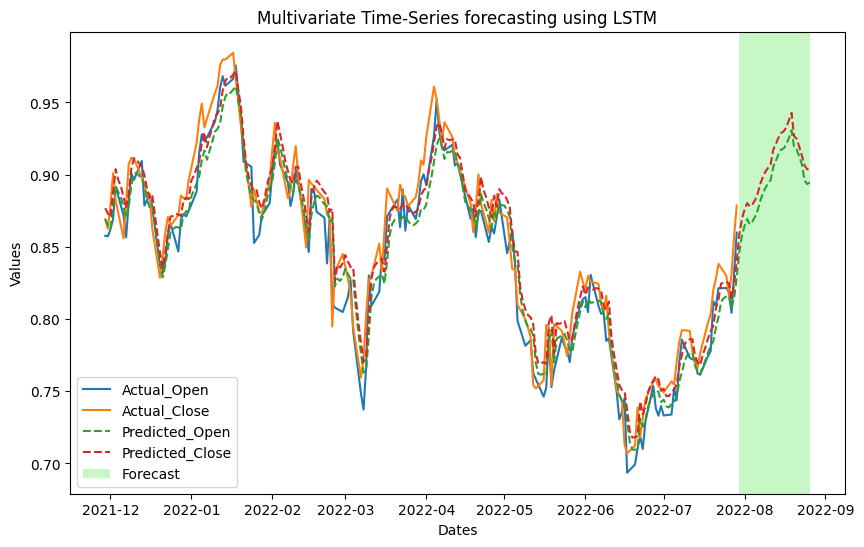

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(d) * 0.9)  
highlight_end = len(d) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [13]:
# Model Evaluation
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }

result = dict()

for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)

print('Predicted Open', result['Predicted_Open'])
print('Predicted Close', result['Predicted_Close'])

Predicted Open {'MSE': 0.00019457661331164313, 'MAE': 0.01075630112671325, 'R2': 0.9527797670170193}
Predicted Close {'MSE': 0.0002743061293831372, 'MAE': 0.013073297037485233, 'R2': 0.9324627730656305}
